In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
from datetime import datetime
from scipy.stats import norm

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"

# location folders
data_in = dirname + "da_data_repo/sp500/clean/"
data_out = dirname + "da_case_studies/ch05-stock-market-loss-generalize/"
output = dirname + "da_case_studies/ch05-stock-market-loss-generalize/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions 
from py_helper_functions import *

In [4]:
sp500 = (
    pd.read_csv(data_in + "SP500_2006_16_data.csv")
    .replace("", np.nan)
    .replace("#N/A", np.nan)
)
sp500 = sp500.dropna().reset_index(drop=True)

In [5]:
# CREATE PERCENT RETURN
sp500["pct_return"] = (
    sp500["VALUE"] - sp500.set_index("DATE").shift(1).reset_index(drop=True)["VALUE"]
) / sp500.set_index("DATE").shift(1).reset_index(drop=True)["VALUE"]*100

In [6]:
sp500['DATE']=pd.to_datetime(sp500['DATE'],format='%Y-%m-%d')
sp500['year']=sp500['DATE'].apply(lambda x: x.year)
sp500['month']=sp500['DATE'].apply(lambda x: x.month)
sp500['yearmonth']=sp500['year']*100+sp500['month']

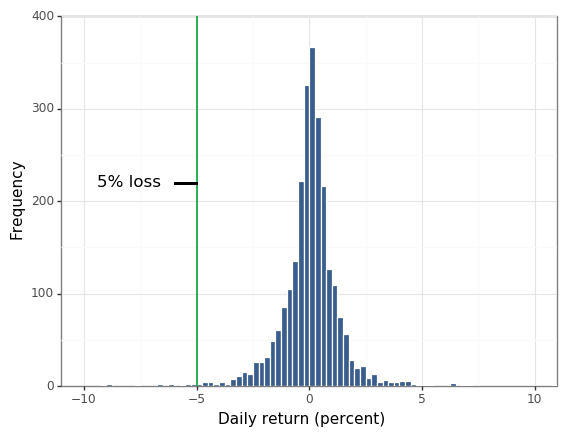

<ggplot: (8775430590624)>

In [7]:
ggplot(sp500, aes("pct_return")) + geom_histogram(binwidth=0.25,color="white",fill=color[0],boundary=0,closed="left") + geom_vline(
    xintercept=-5, size=0.7, color=color[1]
) + labs(x="Daily return (percent)", y="Frequency") + coord_cartesian(
    xlim=[-10, 10], ylim=[0, 400]
) + scale_y_continuous(
    expand=[0, 0]
) + geom_segment(
    aes(x=-6, y=220, xend=-5, yend=220)
) + annotate(
    "text", x=-8, y=220, label="5% loss", size=12
) + theme_bw()

In [8]:
pct_return=sp500.pct_return.dropna()

In [9]:
def create_samples(vector,n_samples, n_obs):
    samples_pcloss=[None] * (n_samples+1)
    for i in range(1,n_samples+1):
            single_sample=np.random.choice(vector, size=n_obs, replace=False)
            samples_pcloss[i]=sum(single_sample < -5) / n_obs*100
    return samples_pcloss

In [10]:
np.random.seed=123

In [11]:
nobs_1000 = create_samples(pct_return, 10000, 1000)
nobs_500 = create_samples(pct_return, 10000, 500)
#nobs_df <- as.data.frame(cbind(nobs_500, nobs_1000))

In [12]:
nobs_df = pd.DataFrame({"nobs_500": nobs_500, "nobs_1000": nobs_1000}).drop(0)

In [13]:
nobs_df

,nobs_500,nobs_1000
1,0.6,0.2
2,0.4,0.5
3,0.8,0.4
4,0.4,0.6
5,0.6,0.6
...,...,...
9996,0.6,0.7
9997,0.4,0.4
9998,0.2,0.4
9999,0.6,0.3


In [14]:
error = norm.ppf(0.975) * np.std(nobs_df["nobs_1000"]) / np.sqrt(len(nobs_df["nobs_1000"]))
left = np.mean(nobs_df["nobs_1000"]) - error
right = np.mean(nobs_df["nobs_1000"]) + error

In [15]:
# Figure 5.2
ggplot(nobs_df, aes(nobs_1000[1:])) + geom_histogram(
    binwidth=0.1, color="white", fill=color[0], alpha=0.8, center=0,boundary=0,closed="left"
) + labs(x="Percent of days with losses of 5% or more", y="Frequency") + geom_vline(
    aes(xintercept=np.mean(pd.Series(nobs_500).dropna())), color=color[1], size=0.7
) + coord_cartesian(
    xlim=[0, 1.5], ylim=(0, 2500)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 1.5), breaks=seq(0, 1.6, 0.25)
) + scale_y_continuous(
    expand=(0.00, 0.00), limits=(0, 2500), breaks=seq(0, 2500, 501)
) + geom_segment(
    aes(x=0.8, y=2000, xend=0.53, yend=2000)
) + annotate(
    "text", x=0.85, y=2200, label="Mean", size=12
) + theme_bw()

PlotnineError: "Only one of 'boundary' and 'center' may be specified."

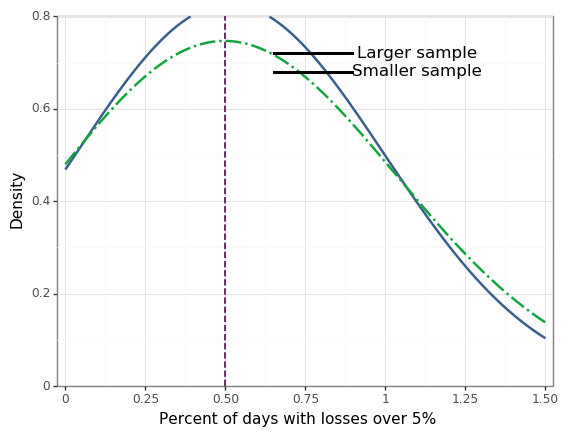

<ggplot: (8775430280708)>

In [16]:
# Figure 5.3 - NOt working with epanechnikov kernel
ggplot(nobs_df, aes(x="nobs_1000")) + stat_density(
    color=color[0], geom="line", bw=0.45, size=1
) + stat_density(
    aes("nobs_500"), color=color[1], geom="line", bw=0.45, linetype="dashdot", size=1
) + labs(
    x="Percent of days with losses over 5%", y="Density"
) + geom_vline(
    xintercept=0.5, color=color[2], size=0.7, linetype="dashed"
) + geom_segment(
    aes(x=0.9, y=0.72, xend=0.65, yend=0.72), size=0.5,
) + annotate(
    "text", x=1.1, y=0.72, label="Larger sample", size=12
) + geom_segment(
    aes(x=0.9, y=0.68, xend=0.65, yend=0.68), size=0.5
) + annotate(
    "text", x=1.1, y=0.68, label="Smaller sample", size=12
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 1.5), breaks=seq(0, 1.51, 0.25)
) + scale_y_continuous(
    expand=(0.00, 0.00), limits=(0, 0.8), breaks=seq(0, 0.81, 0.2)
) + theme_bw() + theme(
    legend_position="none"
)

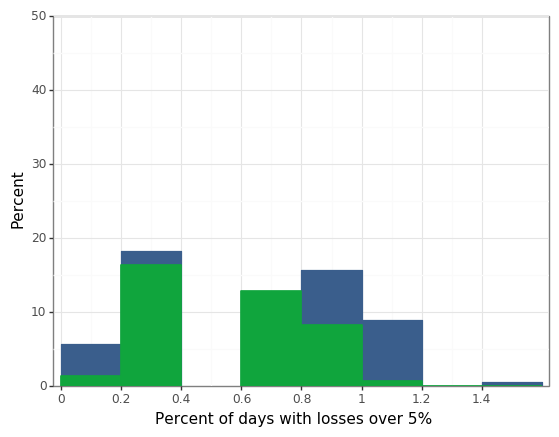

<ggplot: (8775429264267)>

In [26]:
# ALPHA not working
ggplot(nobs_df) + geom_histogram(
    aes(x="nobs_500", y="stat(count)/sum(stat(count))*100"),
    color=color[0],
    fill=color[0],
    binwidth=0.2,
    boundary=0,
    alpha=0.7,
    closed="left"
) + geom_histogram(
    aes(x="nobs_1000", y="stat(count)/sum(stat(count))*100"),
    color=color[1],
    fill=color[1],
    binwidth=0.2,
    boundary=0,
    alpha=0.1,
    size=0.7,
    closed="left"
) + ylab(
    "Percent"
) + xlab(
    "Percent of days with losses over 5%"
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 1.6), breaks=seq(0, 1.6, 0.2)
) + scale_y_continuous(
    expand=(0.00, 0.00), limits=(0, 50)
) + scale_color_manual(
    name="", values=(color[1], color[0])
) + scale_fill_manual(
    name="", values=(color[1], color[0])
) + theme_bw() + theme(
    legend_direction="horizontal",
)

In [18]:
nobs_df["nobs_500"].value_counts(sort=True,normalize=True)

0.4    0.2741
0.6    0.2351
0.2    0.1818
0.8    0.1563
1.0    0.0674
0.0    0.0562
1.2    0.0219
1.4    0.0060
1.6    0.0010
1.8    0.0002
Name: nobs_500, dtype: float64

In [19]:
nobs_df["nobs_1000"].value_counts(sort=True,normalize=True)

0.5    0.2224
0.6    0.1986
0.4    0.1842
0.7    0.1288
0.3    0.1166
0.8    0.0632
0.2    0.0466
0.9    0.0196
0.1    0.0117
1.0    0.0055
1.1    0.0015
0.0    0.0012
1.2    0.0001
Name: nobs_1000, dtype: float64

In [20]:
####################################
#BOOTSRTAP SAMPLES
np.random.seed=573164
M = 10000
Results=np.zeros((M,10))

In [21]:
for i in range(1,M+1):
    bsample=np.random.choice(sp500['pct_return'], size=sp500.shape[0], replace=True)
    for j in range(1,11):
            loss=pd.Series(bsample<(-j)).apply(lambda x: float(x))*100
            Results[i-1,j-1]=np.mean(loss)

In [22]:
Results = pd.DataFrame(
    Results,
    columns=[
        "loss1",
        "loss2",
        "loss3",
        "loss4",
        "loss5",
        "loss6",
        "loss7",
        "loss8",
        "loss9",
        "loss10",
    ],
)

In [23]:
Results

,loss1,loss2,loss3,loss4,loss5,loss6,loss7,loss8,loss9,loss10
0,14.529575,5.041683,2.064311,1.270345,0.714569,0.595474,0.238190,0.119095,0.039698,0.0
1,14.926558,5.478364,2.143708,0.992457,0.595474,0.396983,0.198491,0.079397,0.039698,0.0
2,13.656213,5.121080,2.262803,1.071854,0.555776,0.357285,0.198491,0.158793,0.000000,0.0
3,13.418023,4.763795,1.865820,0.992457,0.635173,0.396983,0.198491,0.119095,0.039698,0.0
4,14.767765,5.597459,1.826121,0.873362,0.357285,0.277888,0.079397,0.079397,0.079397,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,13.815006,5.160778,2.421596,1.349742,0.714569,0.436681,0.317586,0.238190,0.119095,0.0
9996,13.934101,4.962287,1.984915,1.190949,0.635173,0.396983,0.238190,0.238190,0.039698,0.0
9997,13.537118,4.882890,1.667328,0.793966,0.317586,0.198491,0.119095,0.079397,0.039698,0.0
9998,13.298928,5.121080,1.945216,1.071854,0.635173,0.357285,0.198491,0.119095,0.079397,0.0


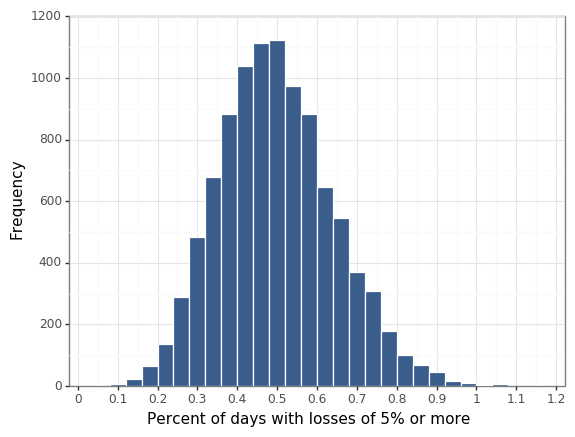

<ggplot: (8775430378816)>

In [24]:
ggplot(Results, aes("loss5")) + geom_histogram(fill=color[0], color="white",binwidth=0.04,boundary=0,closed="left"
) + scale_y_continuous(
    expand=(0, 0), limits=(0, 1200), breaks=seq(0, 1201, 200)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 1.2), breaks=seq(0, 1.21, 0.1)
) + labs(
    x="Percent of days with losses of 5% or more", y="Frequency"
) + theme_bw()